In [ ]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.applications.xception import Xception
from keras.applications.resnet import ResNet50
from keras.models import Model

from keras.utils import load_img
from keras.utils import img_to_array
from nltk.translate.bleu_score import corpus_bleu
from keras.callbacks import ReduceLROnPlateau
from keras.applications.xception import preprocess_input
from keras.models import Model
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers import Embedding
from keras.layers import RepeatVector

import string
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
from keras.utils import pad_sequences
from keras.utils import plot_model
from keras.layers import Input



# Dataset Description:
 * Flickr8k.token.txt: Text File that contains line. Each line has the following format: [Image_Name] + [Caption_Number] + [Caption]
 * Flickr_8k.trainImages: Text File that contains Image Names that will be used in Model Training   [6000 Images]
 * Flickr_8k.testImages: Text File that contains Image Names that will be used in Model Testing    [1000 Images]
 * Flickr_8k.devImages: Text File that contains Image Names that will be used in Validation    [1000 Images]
 * Flickr8k_Dataset: Folder that contains All Images named by Image Names that was provided in each of the text files.

# Dataset Preprocessing

## 1) Dealing with Flickr8k_token.txt

* In this step, we used Flickr8k_token.txt File to separate each image with only its Captions. 
* Each Image has 5 Caption.
* Output of this step is a dict with the size of all images.
* The key of each entry is the image name, and the value is the 5 captions.

In [ ]:
#Rading the text file
filename = "data/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()
file.close()

In [ ]:
doc[:1000]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

* As shown, the format is as follows [Image_Name] + [Caption_Number] + [Caption], then \n which is a new line.


* We need to split and separate the captions and make a dict that contains Each Image and its captions.

In [ ]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()  #split each line 
        image_name  = tokens[0] 
        image_id = image_name.split('.')[0]  #image_id is the name without .jpg
        image_desc = tokens[1:]  #caption
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)  #append all captions for each image
    except :
        print(line)

* Sample from the Dict that has Images and Captions of each image

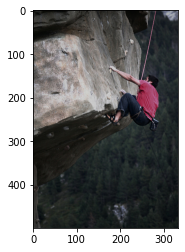

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [ ]:
x = plt.imread('data/Flickr8k_Dataset/'+image_id+'.jpg')
plt.imshow(x)
plt.show()
descriptions[image_id]


## Captions Preprocessing

In this step, we want to:
1. lower case all the words 
2. Vectorize words with tokenzer 
3. Prepare a dictionary that has key = imageID and value= List()
4. Encapsulate all the captions with \<startSeq> \<endSeq>
5. count the number of unique words to set the maxLength


#### Tokenization, Punctuations, Lower Case.

In [ ]:
descriptions_clean = descriptions
xc = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions_clean.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split() # tokenization
        desc = [word.lower() for word in desc] #lower case conversion
        desc = [w.translate(xc) for w in desc]
        desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
        desc_list[i] =  ' '.join(desc)

In [ ]:
descriptions_clean[image_id]

['a man in a pink shirt climbs a rock face',
 'a man is rock climbing high in the air',
 'a person in a red shirt climbing up a rock face covered in assist handles',
 'a rock climber in a red shirt',
 'a rock climber practices on a rock climbing wall']

#### Encapsulate all the captions with \<startSeq> \<endSeq>

In [ ]:
for key in descriptions_clean:
        for i in range(len(descriptions_clean[key])):
            descriptions_tokenSE[key][i] = '<startseq>' + ' ' + descriptions[key][i] + ' ' + '<endseq>'

In [ ]:
descriptions_tokenSE[image_id]

['<startseq> a man in a pink shirt climbs a rock face <endseq>',
 '<startseq> a man is rock climbing high in the air <endseq>',
 '<startseq> a person in a red shirt climbing up a rock face covered in assist handles <endseq>',
 '<startseq> a rock climber in a red shirt <endseq>',
 '<startseq> a rock climber practices on a rock climbing wall <endseq>']

#### By this step, we are done with captions preprocessing.

## 2) Dealing with Flickr_8k.testImages.txt, Flickr_8k.trainImages.txt, Flickr_8k.devImages.txt

In this step, we will Load Training, Testing and Validation Datasets.

In [ ]:
# Train Image Names
file = open('data/Flickr_8k.trainImages.txt', 'r')
doc = file.read()
file.close()
dataset = list()
for line in doc.split('\n'):
	if len(line) < 1:
		continue
	identifier = line.split('.')[0]
	dataset.append(identifier)
train_imgs_names = list(set(dataset))

# Test Image Names
file = open('data/Flickr_8k.testImages.txt', 'r')
doc = file.read()
file.close()
dataset = list()
for line in doc.split('\n'):
	if len(line) < 1:
		continue
	identifier = line.split('.')[0]
	dataset.append(identifier)
test_imgs_names = list(set(dataset))


# Val Image Names
file = open('data/Flickr_8k.devImages.txt', 'r')
doc = file.read()
file.close()
dataset = list()
for line in doc.split('\n'):
	if len(line) < 1:
		continue
	identifier = line.split('.')[0]
	dataset.append(identifier)
dev_imgs_names = list(set(dataset))

In [ ]:
len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [ ]:
train_descriptions = {}
test_descriptions = {}
dev_descriptions = {}

# Train Captions
for image_id in train_imgs_names:
    train_descriptions[image_id] = descriptions_tokenSE[image_id]

# Val Captions
for image_id in dev_imgs_names:
    dev_descriptions[image_id] = descriptions_tokenSE[image_id]

# Test Captions
for image_id in test_imgs_names:
    test_descriptions[image_id] = descriptions_tokenSE[image_id]



* Sample from the Test Data

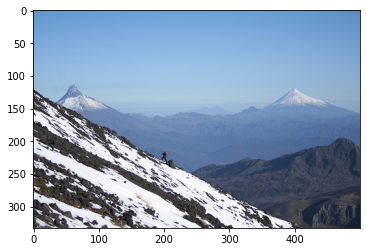

['<startseq> a man is climbing the mountain <endseq>',
 '<startseq> a mountain climber is seen on the side of a tall mountain <endseq>',
 '<startseq> a solitary climber on snowy high mountains <endseq>',
 '<startseq> snow covered mountains with a person walking up in the background <endseq>',
 '<startseq> the mountaintop is filled with snow <endseq>']

In [ ]:
x = plt.imread('data/Flickr8k_Dataset/'+image_id+'.jpg')
plt.imshow(x)
plt.show()
test_descriptions[image_id]

#### Remove any Numbers and Special Characters.

In [ ]:
all_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_captions.append(cap)
word_counts = {}
nsents = 0
for sent in all_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= 5]
oov_token = '<UNKOWN>'
filters = '*+!&()",-./:;=?@[\\]#$%^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 2535


#### Convert Words to Index Vectors

In [ ]:
#Words to index
ixtoword = {}  
wordtoix = {} 
tokenizer.word_index['<PAD0>'] = 0     # We will use zeros to pad, we no words will have index 0
wordtoix = tokenizer.word_index   
for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### Finding Suitable Length for Sequences to use for Training

* We will set the maximum length with the the length of 90% of sentences in the dataset. ..90 Percentile..

In [ ]:
all_desc = []
for i in train_descriptions:
    for j in train_descriptions[i]:
        all_desc.append(j)
length_all_desc = list(len(d.split()) for d in all_desc)
max_length = int(np.percentile(length_all_desc, 90))

In [ ]:
max_length

18

# Image Feature Extraction

* In this step, we will try to extract the features from Images.
* We will use two models for Image Feature Extraction (ResNet50, Xecption)

## 1) ResNet50

* Building the Model

In [ ]:
resnet = ResNet50()
extractor_1 = Model(inputs=resnet.inputs, outputs=resnet.layers[-2].output)
print(extractor_1.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
def extract_features(description, model, inpute_size = (229,229)):
    directory = 'data\\Flickr8k_Dataset'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features


### Feature Extraction for Train, Test, Validation Images

In [ ]:
# Train Images
train_features_resnet = {}
for name in train_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor_1.predict(image, verbose=0)
    image_id = name.split('.')[0]
    train_features_resnet[image_id] = feature.reshape(2048)

# Test Images
test_features_resnet = {}
for name in test_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor_1.predict(image, verbose=0)
    image_id = name.split('.')[0]
    test_features_resnet[image_id] = feature.reshape(2048)

# Val Images
dev_features_resnet = {}
for name in dev_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor_1.predict(image, verbose=0)
    image_id = name.split('.')[0]
    dev_features_resnet[image_id] = feature.reshape(2048)


## 2) Xception

* Building the Model

In [ ]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

### Feature Extraction for Train, Test, Validation Images

In [ ]:
# Train Images
train_features_Xception = {}
for name in train_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor.predict(image, verbose=0)
    image_id = name.split('.')[0]
    train_features_Xception[image_id] = feature.reshape(2048)

# Test Images
test_features_Xception = {}
for name in test_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor.predict(image, verbose=0)
    image_id = name.split('.')[0]
    test_features_Xception[image_id] = feature.reshape(2048)

# Val Images
dev_features_Xception = {}
for name in dev_descriptions:
    filename =os.path.join('data\\Flickr8k_Dataset', name+'.jpg')
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = extractor.predict(image, verbose=0)
    image_id = name.split('.')[0]
    dev_features_Xception[image_id] = feature.reshape(2048)


# Word Embedding Layer

#### For Word Embedding, we will use Glove which is a corpus that includes 400K, where each word has a size of 50, 100, 200, or 300 dimensions.
#### In our implmentation, we will use Glove with 50d, Glove with 300d, and embedding layer without using Glove.
#### A comparison between the effect of each Embedding Layer will be held using the 2 Image Feature Extractor Models (ResNet50, Xecption)

**Embedding Layer without Glove**

In [ ]:
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_layer_no_glove = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
embedding_layer_no_glove.build((None,))
embedding_layer_no_glove.set_weights([embedding_matrix])

**Embedding Layer with Glove 300d**

In [ ]:
embedding_dim = 300
embeddings_index = {} 
f = open(os.path.join('glove\glove.6B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer_300 = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
embedding_layer_300.build((None,))
embedding_layer_300.set_weights([embedding_matrix])

**Embedding Layer with Glove 50d**

In [ ]:
embedding_dim = 50
embeddings_index = {} 
f = open(os.path.join('glove\glove.6B.50d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_layer_50 = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
embedding_layer_50.build((None,))
embedding_layer_50.set_weights([embedding_matrix])

# Data Genarator

* This Data Generator is used to obtain batches of captions and images to be fed to the model with training

In [ ]:
emb_dim = 50
batch_size = 32

In [ ]:
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences(desc.split())
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] 
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

# Loss Function

In [ ]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# Constructing the Models

#### Since we will be using 2 Image Features Extractors and 3 Embedding Layers, we will make a funciton that will take the embedded layer.

In [ ]:
def Build_Model_(embedding_layer):
    # Image Model
    features = Input(shape=(2048,))
    X_fe_one_dim = Dense(256, activation='relu')(features)                                              
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(0.2)(X_fe)
    
    # Language Model
    seq = Input(shape=(max_length,))
    X_seq = embedding_layer(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq)
    X_seq = Dropout(0.2)(X_seq)

    # Full Architecture
    X_seq = Concatenate(axis=-1)([X_fe,X_seq])
    X_seq = GRU(256, return_sequences=True)(X_seq,initial_state=X_fe_one_dim) 
    X_seq = Dropout(0.4)(X_seq)
    X_seq = GRU(256, return_sequences=False)(X_seq)
    outputs = Dense(vocab_size, activation='softmax')(X_seq)
    model = Model(inputs=[features, seq], outputs = outputs)
    return model

#### Here are the functions that will be used to evaluate the model.

* The models will be tested in 2 main approaches: Greedy and Beam Search.

* generate_desc Function is used to generate captions for images using the words with highest probability.

* beam_search_pred Function is used to generate captions for images using beam search approach with different K values.

* evaluate_model Funciton is used to find the BLEU Scores using the greedy predictions.

In [ ]:
def generate_desc(model, photo_fe):
    in_text = '<startseq>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences(in_text.split()) 
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        yhat = model.predict([photo_fe,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == '<endseq>':
            break     
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:]
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text) 
    return in_text


def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3):
    start = [wordtoix['<startseq>']]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length))
            preds = model.predict([pic_fe.reshape(1,2048), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != '<endseq>':
            final_caption.append(i)
        else:
            break
    final_caption = ' '.join(final_caption[1:])
    return final_caption


def evaluate_model(model, descriptions, photos_fe, K_beams= 3):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams)       
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())        
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)

#### 1) Model that uses ResNet50 and Glove 300d

#### Compiling the Model

In [ ]:
model = Build_Model_(embedding_layer_300)
model.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)


In [ ]:
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_3[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 18, 300)      760500      ['input_4[0][0]']                
                                                                      

#### Model Training

In [ ]:
steps = len(train_descriptions)//batch_size
generator_resnet = data_generator(train_descriptions, train_features_resnet)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model.fit_generator(generator_resnet, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])
    print('\n','='*80)

#### Model Testing

#### 1) Greedy (Choosing Word with highest Probability)

In [ ]:
evaluate_model(model=model,descriptions=test_descriptions,photos_fe=test_features_resnet,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.517942
BLEU-2: 0.316387
BLEU-3: 0.212321
BLEU-4: 0.103534


# Test Cases

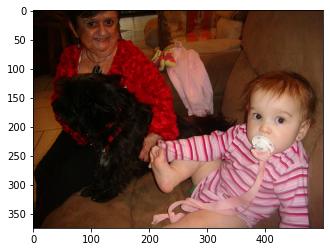

Greedy: a young boy in a blue shirt is laying on a red blanket
Beam K= 3: a little girl in a pink bathing suit is swimming in a pool
Beam K= 5: a little girl in a pink bathing suit is swimming in a pool
Beam K= 7: a little girl in a bathing suit plays with a stuffed animal
Beam K= 10: a little girl in a bathing suit plays with a stuffed animal


In [ ]:
pic = list(test_features_resnet.keys())[115]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

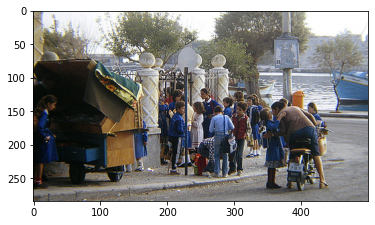

Greedy: a group of people are riding bicycles on a boat
Beam K= 3: a group of people are riding bicycles on a raft
Beam K= 5: a group of people are riding bicycles down a hill
Beam K= 7: a group of people are riding bicycles down a hill
Beam K= 10: a group of people are riding bicycles on a beach


In [ ]:
pic = list(test_features_resnet.keys())[25]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

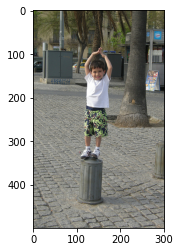

Greedy: a boy in a red shirt is running through a grassy area
Beam K= 3: a young boy wearing a blue shirt is running through a grassy area
Beam K= 5: a young boy wearing a yellow shirt is jumping into a swimming pool
Beam K= 7: a young boy wearing a red shirt is jumping into a swimming pool
Beam K= 10: a black and white dog jumps over a log


In [ ]:
pic = list(test_features_resnet.keys())[750]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

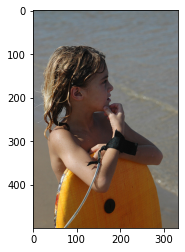

Greedy: a man in a white shirt and jeans is running down a snowy hill
Beam K= 3: a young girl in a pink bathing suit stands in a field of snow
Beam K= 5: a little girl in a pink jacket is running on a beach
Beam K= 7: a little girl in a pink bathing suit is sitting on a rock next to water
Beam K= 10: a white dog with a red collar runs through the snow


In [ ]:
pic = list(test_features_resnet.keys())[444]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

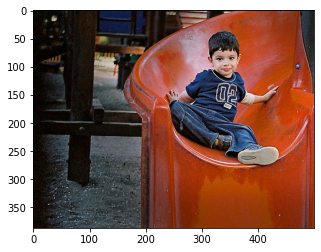

Greedy: a man in a red jacket and a man in a yellow shirt is running in a
Beam K= 3: a man in a red jacket and a man in a blue shirt is running down a
Beam K= 5: a little girl in a yellow dress plays with a soccer ball at a park
Beam K= 7: a little girl in a yellow dress kicks a soccer ball during a game
Beam K= 10: a little girl in a yellow dress jumps into a pool


In [ ]:
pic = list(test_features_resnet.keys())[499]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

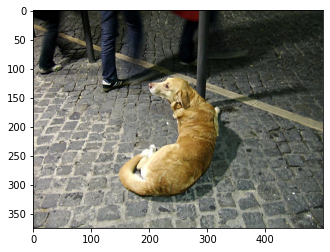

Greedy: a dog running through a field
Beam K= 3: a brown and white dog running through a grassy area
Beam K= 5: a black and white dog is running through a grassy area
Beam K= 7: a black and white dog jumps over a log
Beam K= 10: a black and white dog jumps over a log


In [ ]:
pic = list(test_features_resnet.keys())[800]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe))
print("Beam K= 3:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model, test_features_resnet[pic], wordtoix, K_beams = 10))

# 2) Model that uses ResNet50 with Glove 50d

#### Compiling the Model

In [ ]:
model_1 = Build_Model_(embedding_layer_50)
model_1.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
model_1.summary()

In [ ]:
model_1.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          524544      ['input_5[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 18, 50)       126750      ['input_6[0][0]']                
                                                                      

#### Model Training

In [ ]:
generator_resnet = data_generator(train_descriptions, train_features_resnet)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model_1.fit_generator(generator_resnet, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])    
    print('\n','='*80)

#### Model Testing

#### Greedy (Choosing words with Highest Probability)

In [ ]:
evaluate_model(model=model_1,descriptions=test_descriptions,photos_fe=test_features_resnet,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.553598
BLEU-2: 0.343159
BLEU-3: 0.238214
BLEU-4: 0.127202


# Test Cases

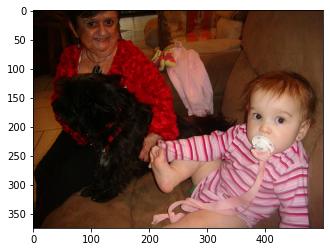

Greedy: a young boy with a broken arm asleep down
Beam K= 3: a young boy with a broken arm asleep on his bed
Beam K= 5: a young boy with a broken arm on his head laughs
Beam K= 7: a young boy with a broken arm on his head laughs
Beam K= 10: a young boy with a broken arm on his head laughs


In [ ]:
pic = list(test_features_resnet.keys())[115]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

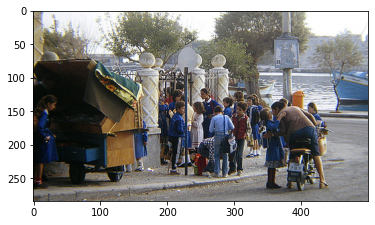

Greedy: a group of people are standing in front of a mountain range
Beam K= 3: a group of climbers ascending a snowy mountain
Beam K= 5: a group of climbers ascending a snowy mountain
Beam K= 7: a group of climbers ascending the side of a mountain
Beam K= 10: a group of climbers ascending a snowy mountain


In [ ]:
pic = list(test_features_resnet.keys())[25]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

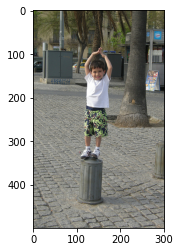

Greedy: a boy in a blue shirt is running on a track
Beam K= 3: a dog jumps to catch a tennis ball in a grassy field
Beam K= 5: a young boy dives in the air on a pathway
Beam K= 7: a brown and white dog is jumping up to catch a tennis ball in its mouth
Beam K= 10: a black and white dog catches a tennis ball in his mouth


In [ ]:
pic = list(test_features_resnet.keys())[750]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

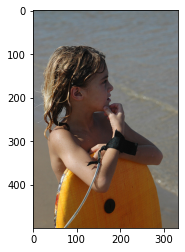

Greedy: a man is sitting on a folding in a field
Beam K= 3: a black and white dog is running through the snow
Beam K= 5: a black and white dog is standing on its hind legs in front of a purple blanket
Beam K= 7: a black and white dog is catching a tennis ball in its mouth
Beam K= 10: a black and white dog is playing with a soccer ball in a grassy field


In [ ]:
pic = list(test_features_resnet.keys())[444]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

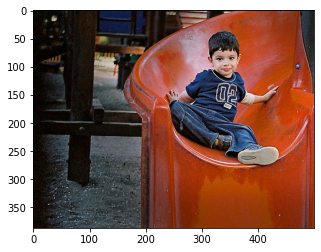

Greedy: a man in a black shirt is standing in a stadium with a man in a black
Beam K= 3: a man in a blue shirt is standing in front of a white building
Beam K= 5: a man in a blue shirt is standing in front of a restaurant
Beam K= 7: a man dressed in a batman costume holding a very large camera
Beam K= 10: a man dressed in a batman costume in front of a crowd


In [ ]:
pic = list(test_features_resnet.keys())[499]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

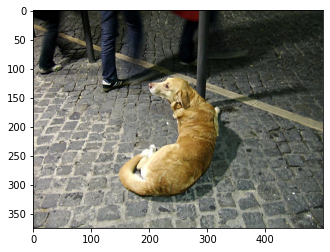

Greedy: a dog is running through the snow
Beam K= 3: a black and white dog is running through a field of grass
Beam K= 5: a black and white dog is playing with a soccer ball outside
Beam K= 7: a black and white dog is playing with a soccer ball outside
Beam K= 10: a black and white dog is catching a tennis ball in its mouth


In [ ]:
pic = list(test_features_resnet.keys())[800]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_1, fe))
print("Beam K= 3:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_1, test_features_resnet[pic], wordtoix, K_beams = 10))

# 3) Model that uses ResNet50 with No Glove

#### Compiling the Model

In [ ]:
model_2 = Build_Model_(embedding_layer_no_glove)
model_2.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)


In [ ]:
model_2.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 256)          524544      ['input_7[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 18, 50)       126750      ['input_8[0][0]']                
                                                                      

#### Model Training

In [ ]:
generator_resnet = data_generator(train_descriptions, train_features_resnet)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model_2.fit_generator(generator_resnet, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])    
    print('\n','='*80)

187/187 [==============================] - 42s 222ms/step - loss: 4.3921 - lr: 0.0010

Epoch : 23 

187/187 [==============================] - 40s 213ms/step - loss: 4.3749 - lr: 0.0010

Epoch : 24 

187/187 [==============================] - 36s 195ms/step - loss: 4.3607 - lr: 0.0010

Epoch : 25 

187/187 [==============================] - 36s 194ms/step - loss: 4.3499 - lr: 0.0010

Epoch : 26 

187/187 [==============================] - 36s 194ms/step - loss: 4.3465 - lr: 0.0010

Epoch : 27 

187/187 [==============================] - 36s 194ms/step - loss: 4.3397 - lr: 0.0010

Epoch : 28 

187/187 [==============================] - 36s 193ms/step - loss: 4.3228 - lr: 0.0010

Epoch : 29 

187/187 [==============================] - 36s 194ms/step - loss: 4.3049 - lr: 0.0010

Epoch : 30 

187/187 [==============================] - 36s 194ms/step - loss: 4.2890 - lr: 0.0010

Epoch : 31 

187/187 [==============================] - 37s 196ms/step - loss: 4.2805 - lr: 0.0010

Epoch : 32 



#### Model Testing

#### Greedy (Choosing words with Highest Probability)

In [ ]:
evaluate_model(model=model_2,descriptions=test_descriptions,photos_fe=test_features_resnet,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.535028
BLEU-2: 0.297881
BLEU-3: 0.188988
BLEU-4: 0.089115


# Test Cases

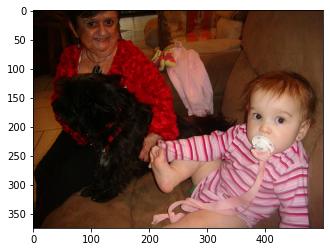

Greedy: a man in a a a a
Beam K= 3: a man in a a a a
Beam K= 5: a man in a a a a
Beam K= 7: a man in a a a a
Beam K= 10: a man in a a a a


In [ ]:
pic = list(test_features_resnet.keys())[115]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

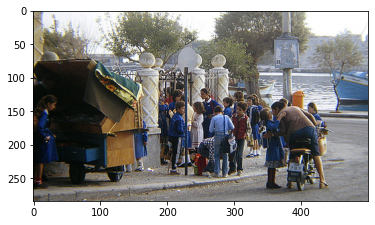

Greedy: a group of people a a a a
Beam K= 3: a group of people a a a a
Beam K= 5: a group of people a a a a
Beam K= 7: a group of people a a a a
Beam K= 10: a group of people a a a a


In [ ]:
pic = list(test_features_resnet.keys())[25]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

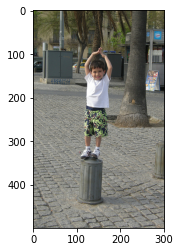

Greedy: a man in a a a and a a
Beam K= 3: a man in a a a and a a
Beam K= 5: a man in a a a and a a
Beam K= 7: a man in a a a and a a
Beam K= 10: a man in a a a and a a


In [ ]:
pic = list(test_features_resnet.keys())[750]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

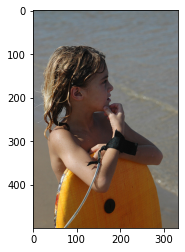

Greedy: a man dog a dog jacket
Beam K= 3: a man dog a dog jacket
Beam K= 5: a man dog a dog jacket
Beam K= 7: a man dog a dog jacket
Beam K= 10: a man dog a dog jacket


In [ ]:
pic = list(test_features_resnet.keys())[444]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

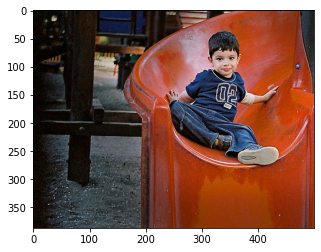

Greedy: a man with a a a a a
Beam K= 3: a man with a a a a a
Beam K= 5: a man with a a a a a
Beam K= 7: a man with a a a a a
Beam K= 10: a man with a a a a a


In [ ]:
pic = list(test_features_resnet.keys())[499]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

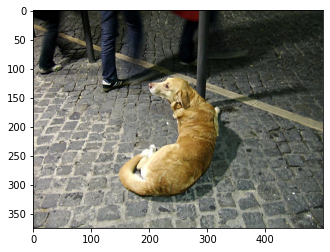

Greedy: a black dog is a a a a
Beam K= 3: a black dog is a a a a
Beam K= 5: a black dog is a a a a
Beam K= 7: a black dog is a a a a
Beam K= 10: a black dog is a a a a


In [ ]:
pic = list(test_features_resnet.keys())[800]
fe = test_features_resnet[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_2, fe))
print("Beam K= 3:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_2, test_features_resnet[pic], wordtoix, K_beams = 10))

# 4) Model that uses Xception with Glove 50d

#### Compiling the Model

In [ ]:
model_4 = Build_Model_(embedding_layer_50)
model_4.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
model_4.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 256)          524544      ['input_9[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 18, 50)       126750      ['input_10[0][0]']               
                                                                      

#### Model Training

In [ ]:
generator_Xception = data_generator(train_descriptions, train_features_Xception)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model_4.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])    
    print('\n','='*80)

Epoch : 1 



C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_15652\1142519164.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model_4.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )


187/187 [==============================] - 45s 215ms/step - loss: 5.0868 - lr: 0.0010

Epoch : 2 

187/187 [==============================] - 40s 213ms/step - loss: 4.6593 - lr: 0.0010

Epoch : 3 

187/187 [==============================] - 40s 213ms/step - loss: 4.2202 - lr: 0.0010

Epoch : 4 

187/187 [==============================] - 40s 213ms/step - loss: 3.8653 - lr: 0.0010

Epoch : 5 

187/187 [==============================] - 40s 214ms/step - loss: 3.5504 - lr: 0.0010

Epoch : 6 

187/187 [==============================] - 40s 214ms/step - loss: 3.3216 - lr: 0.0010

Epoch : 7 

187/187 [==============================] - 40s 213ms/step - loss: 3.1610 - lr: 0.0010

Epoch : 8 

187/187 [==============================] - 40s 212ms/step - loss: 3.0423 - lr: 0.0010

Epoch : 9 

187/187 [==============================] - 40s 212ms/step - loss: 2.9475 - lr: 0.0010

Epoch : 10 

187/187 [==============================] - 40s 213ms/step - loss: 2.8729 - lr: 0.0010

Epoch : 11 

187/187 

#### Model Testing

#### Greedy (Choosing words with Highest Probability)

In [ ]:
evaluate_model(model=model_4,descriptions=test_descriptions,photos_fe=test_features_Xception,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.605276
BLEU-2: 0.406098
BLEU-3: 0.305233
BLEU-4: 0.176107


# Test Cases

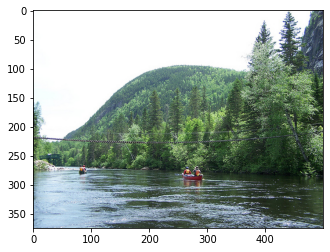

Greedy: a couple of two people in a canoe are crossing past a river
Beam K= 3: two people in a canoe paddle down a river lined by trees
Beam K= 5: two people in a canoe paddle down a river lined by trees
Beam K= 7: two people in a canoe paddle down a river lined by trees
Beam K= 10: two people in a canoe paddle down a river lined by trees


In [ ]:
pic = list(test_features_Xception.keys())[95]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

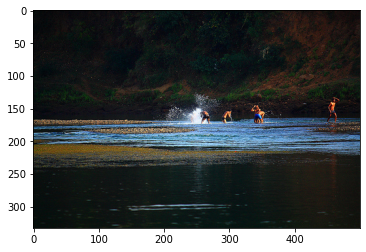

Greedy: two girls are playing in the water under a bridge
Beam K= 3: two girls are playing in the water next to a walkway
Beam K= 5: there are three children playing in the water under a bridge
Beam K= 7: there are three children playing in the water under a bridge
Beam K= 10: there are three children playing in the water under a boardwalk


In [ ]:
pic = list(test_features_Xception.keys())[200]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

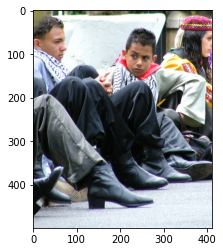

Greedy: a man in a yellow jacket is standing next to a person wearing a blue jacket <endseq>
Beam K= 3: a man in a yellow jacket is standing next to a person wearing a blue jacket
Beam K= 5: a man in an orange jacket is standing next to a group of people carrying bags
Beam K= 7: a man in an orange jacket is standing next to a group of people carrying bags
Beam K= 10: a city worker in a yellow shirt surrounded by <UNK>


In [ ]:
pic = list(test_features_Xception.keys())[250]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

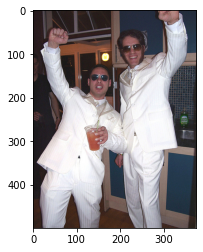

Greedy: two bald men in tuxedos and one white and white are are wearing black dresses and white
Beam K= 3: two bald men dressed in white and white are standing in front of a white curtain one
Beam K= 5: two bald men with shaved heads and white robes pose for a picture
Beam K= 7: two bald men dressed in tuxedos pose for a picture
Beam K= 10: two bald men dressed in tuxedos pose for a picture


In [ ]:
pic = list(test_features_Xception.keys())[300]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

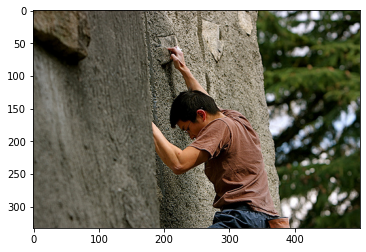

Greedy: a man climbing a steep incline
Beam K= 3: a man climbing a steep incline
Beam K= 5: a man climbing a steep incline
Beam K= 7: a man climbing a steep incline
Beam K= 10: a man climbing a steep incline


In [ ]:
pic = list(test_features_Xception.keys())[370]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

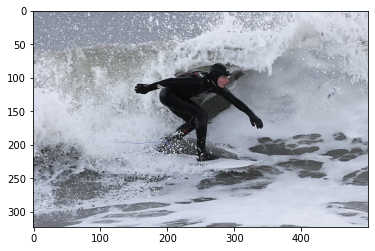

Greedy: two surfers are riding a wave
Beam K= 3: two surfers are in the middle of a crashing wave
Beam K= 5: two surfers riding a wave
Beam K= 7: two surfers riding a wave
Beam K= 10: two surfers riding a wave


In [ ]:
pic = list(test_features_Xception.keys())[800]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_4, fe))
print("Beam K= 3:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_4, test_features_Xception[pic], wordtoix, K_beams = 10))

# 5) Model that uses Xception with Glove 300d

#### Compiling the Model

In [ ]:
model_5 = Build_Model_(embedding_layer_300)
model_5.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
model_5.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 256)          524544      ['input_11[0][0]']               
                                                                                                  
 embedding_1 (Embedding)        (None, 18, 300)      760500      ['input_12[0][0]']               
                                                                      

#### Model Training

In [ ]:
generator_Xception = data_generator(train_descriptions, train_features_Xception)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model_5.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])    
    print('\n','='*80)

Epoch : 1 



C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_15652\1170369284.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model_5.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )


187/187 [==============================] - 46s 218ms/step - loss: 5.0168 - lr: 0.0010

Epoch : 2 

187/187 [==============================] - 41s 220ms/step - loss: 4.4292 - lr: 0.0010

Epoch : 3 

187/187 [==============================] - 41s 218ms/step - loss: 3.9437 - lr: 0.0010

Epoch : 4 

187/187 [==============================] - 41s 218ms/step - loss: 3.5831 - lr: 0.0010

Epoch : 5 

187/187 [==============================] - 41s 218ms/step - loss: 3.3195 - lr: 0.0010

Epoch : 6 

187/187 [==============================] - 41s 219ms/step - loss: 3.1381 - lr: 0.0010

Epoch : 7 

187/187 [==============================] - 41s 218ms/step - loss: 3.0058 - lr: 0.0010

Epoch : 8 

187/187 [==============================] - 41s 218ms/step - loss: 2.9000 - lr: 0.0010

Epoch : 9 

187/187 [==============================] - 41s 219ms/step - loss: 2.8162 - lr: 0.0010

Epoch : 10 

187/187 [==============================] - 41s 218ms/step - loss: 2.7457 - lr: 0.0010

Epoch : 11 

187/187 

#### Model Testing

#### Greedy (Choosing words with Highest Probability)

In [ ]:
evaluate_model(model=model_5,descriptions=test_descriptions,photos_fe=test_features_Xception,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.617114
BLEU-2: 0.418422
BLEU-3: 0.317608
BLEU-4: 0.187548


# Test Cases

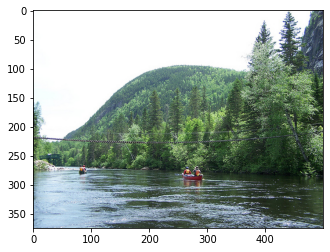

Greedy: a man is rowing a canoe on a lake
Beam K= 3: two people are rowing a canoe through the water
Beam K= 5: a group of people on a lake
Beam K= 7: a group of people on a lake
Beam K= 10: a man rowing a canoe on a lake


In [ ]:
pic = list(test_features_Xception.keys())[95]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

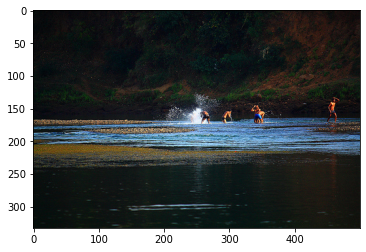

Greedy: two children are playing in a water fountain
Beam K= 3: two children play in the water
Beam K= 5: two children play in the water
Beam K= 7: two children play in the water
Beam K= 10: two children play in the water


In [ ]:
pic = list(test_features_Xception.keys())[200]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

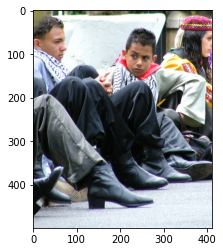

Greedy: a group of people are wearing black shirts and carrying purses
Beam K= 3: a group of people are waiting to cross a busy street
Beam K= 5: a group of people are standing in front of a car
Beam K= 7: a large group of people waiting for a car
Beam K= 10: a group of people are waiting to cross a busy street


In [ ]:
pic = list(test_features_Xception.keys())[250]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

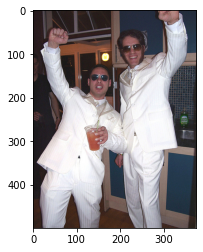

Greedy: four people in white tutus costumes in a crowd
Beam K= 3: a group of people pose for a picture in a race
Beam K= 5: a group of people pose for a picture at night
Beam K= 7: a group of people pose for a picture at night
Beam K= 10: a group of people pose for a picture at night


In [ ]:
pic = list(test_features_Xception.keys())[300]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

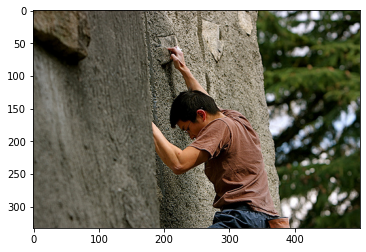

Greedy: a man climbing a wall
Beam K= 3: a man climbing a wall
Beam K= 5: a man climbing a wall
Beam K= 7: a man climbing a wall
Beam K= 10: a man climbing a wall


In [ ]:
pic = list(test_features_Xception.keys())[370]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

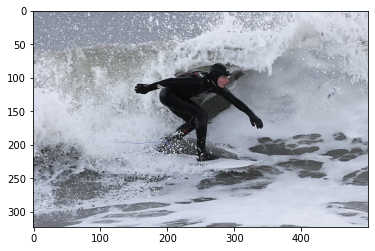

Greedy: a surfer rides a wave
Beam K= 3: a surfer rides a wave on a beach
Beam K= 5: a surfer rides a wave in the ocean
Beam K= 7: a surfer rides a wave in the ocean
Beam K= 10: a surfer rides a wave in the ocean


In [ ]:
pic = list(test_features_Xception.keys())[800]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_5, fe))
print("Beam K= 3:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_5, test_features_Xception[pic], wordtoix, K_beams = 10))

# 6) Model that uses Xception with No Glove

#### Compiling the Model

In [ ]:
model_6 = Build_Model_(embedding_layer_no_glove)
model_6.compile(loss=masked_loss_function, optimizer= 'adam')
history={'loss':[]}
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
model_6.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 18)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 256)          524544      ['input_13[0][0]']               
                                                                                                  
 embedding (Embedding)          (None, 18, 50)       126750      ['input_14[0][0]']               
                                                                      

#### Model Training

In [ ]:
generator_Xception = data_generator(train_descriptions, train_features_Xception)
ep=1

In [ ]:
for i in range(ep, 100):
    print('Epoch :',i,'\n')
    h = model_6.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )
    ep = i + 1
    history['loss'].append(h.history['loss'])    
    print('\n','='*80)

Epoch : 1 



C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_15652\1843590574.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model_6.fit_generator(generator_Xception, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[Reduce_lr] )


187/187 [==============================] - 45s 215ms/step - loss: 5.0504 - lr: 0.0010

Epoch : 2 

187/187 [==============================] - 40s 215ms/step - loss: 4.7544 - lr: 0.0010

Epoch : 3 

187/187 [==============================] - 40s 216ms/step - loss: 4.6383 - lr: 0.0010

Epoch : 4 

187/187 [==============================] - 40s 215ms/step - loss: 4.5431 - lr: 0.0010

Epoch : 5 

187/187 [==============================] - 40s 215ms/step - loss: 4.4526 - lr: 0.0010

Epoch : 6 

187/187 [==============================] - 41s 218ms/step - loss: 4.3825 - lr: 0.0010

Epoch : 7 

187/187 [==============================] - 40s 216ms/step - loss: 4.3143 - lr: 0.0010

Epoch : 8 

187/187 [==============================] - 40s 215ms/step - loss: 4.2480 - lr: 0.0010

Epoch : 9 

187/187 [==============================] - 40s 216ms/step - loss: 4.1883 - lr: 0.0010

Epoch : 10 

187/187 [==============================] - 40s 216ms/step - loss: 4.1322 - lr: 0.0010

Epoch : 11 

187/187 

#### Model Testing

#### Greedy (Choosing words with Highest Probability)

In [ ]:
evaluate_model(model=model_6,descriptions=test_descriptions,photos_fe=test_features_Xception,K_beams=1)

Evaluating Completion: [------------------->] 100%

BLEU-1: 0.543330
BLEU-2: 0.335017
BLEU-3: 0.239280
BLEU-4: 0.125075


# Test Cases

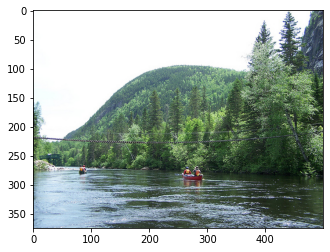

Greedy: two people are a a canoe river river river river river river
Beam K= 3: two people are a a canoe river river river river river river
Beam K= 5: two people are a a canoe river river river river river river
Beam K= 7: two people are a a canoe river river river river river river
Beam K= 10: two people are a a canoe river river river river river river


In [ ]:
pic = list(test_features_Xception.keys())[95]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

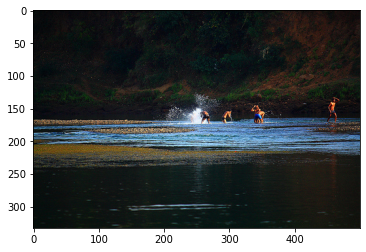

Greedy: a people of people a a a a a
Beam K= 3: a people of people a a a a a
Beam K= 5: a people of people a a a a a
Beam K= 7: a people of people a a a a a
Beam K= 10: a people of people a a a a a


In [ ]:
pic = list(test_features_Xception.keys())[200]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

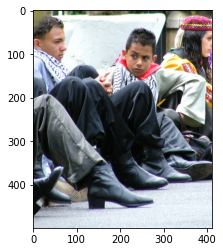

Greedy: two warmly eastern a a street a a street
Beam K= 3: two warmly eastern a a street a a street
Beam K= 5: two warmly eastern a a street a a street
Beam K= 7: two warmly eastern a a street a a street
Beam K= 10: two warmly eastern a a street a a street


In [ ]:
pic = list(test_features_Xception.keys())[250]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

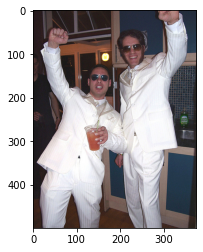

Greedy: a men in a boots and and and a a a
Beam K= 3: a men in a boots and and and a a a
Beam K= 5: a men in a boots and and and a a a
Beam K= 7: a men in a boots and and and a a a
Beam K= 10: a men in a boots and and and a a a


In [ ]:
pic = list(test_features_Xception.keys())[300]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

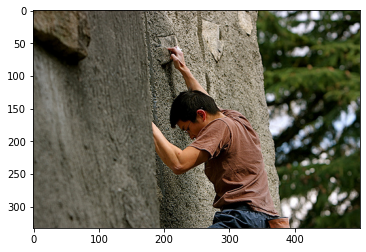

Greedy: a man climbs a clings shirt wall
Beam K= 3: a man climbs a clings shirt wall
Beam K= 5: a man climbs a clings shirt wall
Beam K= 7: a man climbs a clings shirt wall
Beam K= 10: a man climbs a clings shirt wall


In [ ]:
pic = list(test_features_Xception.keys())[370]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

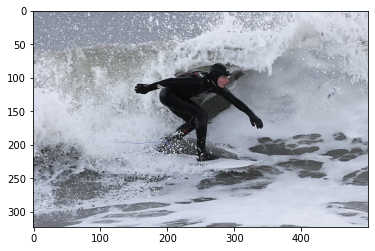

Greedy: a surfer in a black wetsuit a in in in
Beam K= 3: a surfer in a black wetsuit a in in in
Beam K= 5: a surfer in a black wetsuit a in in in
Beam K= 7: a surfer in a black wetsuit a in in in
Beam K= 10: a surfer in a black wetsuit a in in in


In [ ]:
pic = list(test_features_Xception.keys())[800]
fe = test_features_Xception[pic].reshape((1,2048))
x=plt.imread('data/Flickr8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model_6, fe))
print("Beam K= 3:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 3))
print("Beam K= 5:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 5))
print("Beam K= 7:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 7))
print("Beam K= 10:",beam_search_pred(model_6, test_features_Xception[pic], wordtoix, K_beams = 10))

# Test the 6 Models on an image that is not in the dataset

#### Test 1)

In [ ]:
img = 'test_image.jpg'
feature_Res = {}
feature_X = {}

image_Res = load_img(img, target_size=(224, 224))
image_X = load_img(img, target_size=(299, 299))
image_Res = img_to_array(image_Res)
image_X = img_to_array(image_X)
image_Res = image_Res.reshape((1, image_Res.shape[0], image_Res.shape[1], image_Res.shape[2]))
image_Res = preprocess_input(image_Res)
feature_Res = extractor_1.predict(image_Res, verbose=0)
image_X = image_X.reshape((1, image_X.shape[0], image_X.shape[1], image_X.shape[2]))
image_X = preprocess_input(image_X)
feature_X = extractor.predict(image_X, verbose=0)

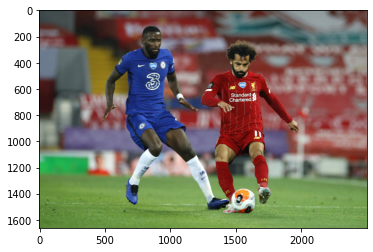

ResNet No Glove (Greedy): a football in football a a progress a a
ResNet No Glove (K= 7)  : a football in football a a progress a a
ResNet 50d (Greedy): a group of people are standing in front of a large gathering of <UNK>
ResNet 50d (K= 7)  : a group of football players in red and white uniforms are huddled together
ResNet 300d (Greedy): a group of people are standing in a line in a field of tulips
ResNet 300d (K= 7)  : a group of football players chase to catch a ball in a field

Xception No Glove (Greedy): a men in a a a
Xception No Glove (K= 7)  : a men in a a a
Xception 50d (Greedy): a soccer player in blue runs with the ball
Xception 50d (K= 7)  : a soccer player kicking the ball during a game
Xception 300d (Greedy): a soccer player in purple uniform attempts to score the ball while the player in white tries
Xception 300d (K= 7)  : a group of men playing soccer on a field


In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print('='*80, '\n')
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))
print('='*80)

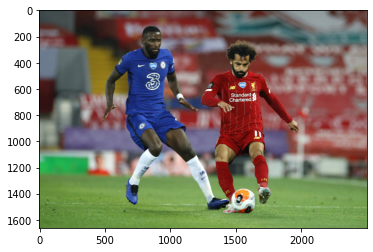

ResNet No Glove (Greedy): a football in football a a progress a a
ResNet No Glove (K= 7)  : a football in football a a progress a a
ResNet 50d (Greedy): a group of people are standing in front of a large gathering of <UNK>
ResNet 50d (K= 7)  : a group of football players in red and white uniforms are huddled together
ResNet 300d (Greedy): a group of people are standing in a line in a field of tulips
ResNet 300d (K= 7)  : a group of football players chase to catch a ball in a field
Xception No Glove (Greedy): a men in a a a
Xception No Glove (K= 7)  : a men in a a a
Xception 50d (Greedy): a soccer player in blue runs with the ball
Xception 50d (K= 7)  : a soccer player kicking the ball during a game
Xception 300d (Greedy): a soccer player in purple uniform attempts to score the ball while the player in white tries
Xception 300d (K= 7)  : a group of men playing soccer on a field


In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))

#### Test 2)

In [ ]:
img = 'test_image3.jpg'
feature_Res = {}
feature_X = {}

image_Res = load_img(img, target_size=(224, 224))
image_X = load_img(img, target_size=(299, 299))
image_Res = img_to_array(image_Res)
image_X = img_to_array(image_X)
image_Res = image_Res.reshape((1, image_Res.shape[0], image_Res.shape[1], image_Res.shape[2]))
image_Res = preprocess_input(image_Res)
feature_Res = extractor_1.predict(image_Res, verbose=0)
image_X = image_X.reshape((1, image_X.shape[0], image_X.shape[1], image_X.shape[2]))
image_X = preprocess_input(image_X)
feature_X = extractor.predict(image_X, verbose=0)

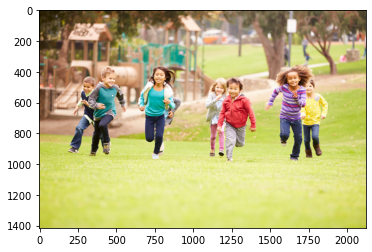

ResNet No Glove (Greedy): a man of children in a a
ResNet No Glove (K= 7)  : a man of children in a a
ResNet 50d (Greedy): a group of people are standing in front of a large gathering of <UNK> <UNK>
ResNet 50d (K= 7)  : a group of people standing in front of a graffitied wall
ResNet 300d (Greedy): a group of people are standing in front of a building with a bunch of people in
ResNet 300d (K= 7)  : a crowd of people are standing in front of a colorful building

Xception No Glove (Greedy): a young and is a a a a a a
Xception No Glove (K= 7)  : a young and is a a a a a a
Xception 50d (Greedy): a girl and girl are playing on a field
Xception 50d (K= 7)  : a group of children are running on the grass
Xception 300d (Greedy): a girl is running with a child in a park
Xception 300d (K= 7)  : a little girl is chasing another child on the grass


In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print('='*80, '\n')
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))
print('='*80)

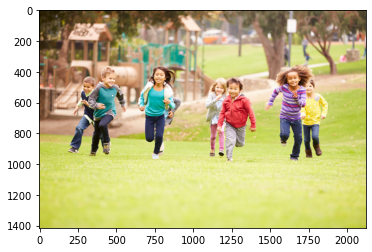

ResNet No Glove (Greedy): a man of children in a a
ResNet No Glove (K= 7)  : a man of children in a a
ResNet 50d (Greedy): a group of people are standing in front of a large gathering of <UNK> <UNK>
ResNet 50d (K= 7)  : a group of people standing in front of a graffitied wall
ResNet 300d (Greedy): a group of people are standing in front of a building with a bunch of people in
ResNet 300d (K= 7)  : a crowd of people are standing in front of a colorful building
Xception No Glove (Greedy): a young and is a a a a a a
Xception No Glove (K= 7)  : a young and is a a a a a a
Xception 50d (Greedy): a girl and girl are playing on a field
Xception 50d (K= 7)  : a group of children are running on the grass
Xception 300d (Greedy): a girl is running with a child in a park
Xception 300d (K= 7)  : a little girl is chasing another child on the grass


In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))

#### Test 3) 

In [ ]:
img = 'test_image2.jpg'
feature_Res = {}
feature_X = {}

image_Res = load_img(img, target_size=(224, 224))
image_X = load_img(img, target_size=(299, 299))
image_Res = img_to_array(image_Res)
image_X = img_to_array(image_X)
image_Res = image_Res.reshape((1, image_Res.shape[0], image_Res.shape[1], image_Res.shape[2]))
image_Res = preprocess_input(image_Res)
feature_Res = extractor_1.predict(image_Res, verbose=0)
image_X = image_X.reshape((1, image_X.shape[0], image_X.shape[1], image_X.shape[2]))
image_X = preprocess_input(image_X)
feature_X = extractor.predict(image_X, verbose=0)

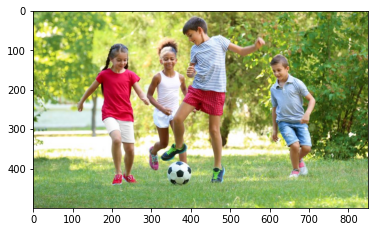

ResNet No Glove (Greedy): a group of children children children children cream cream cream cream cream
ResNet No Glove (K= 7)  : a group of children children children children cream cream cream cream cream
ResNet 50d (Greedy): a group of men in camouflage pants and <UNK> are standing in a line of a busy
ResNet 50d (K= 7)  : a group of men in matching outfits are standing in front of a mountain range
ResNet 300d (Greedy): a group of people are standing in front of a carnival
ResNet 300d (K= 7)  : a group of greyhound dogs racing around a track

Xception No Glove (Greedy): a boys in soccer soccer soccer soccer soccer soccer soccer soccer
Xception No Glove (K= 7)  : a boys in soccer soccer soccer soccer soccer soccer soccer soccer
Xception 50d (Greedy): a group of children are playing soccer in a park
Xception 50d (K= 7)  : a group of children are playing with a soccer ball
Xception 300d (Greedy): a little boy in a blue shirt chasing a soccer ball
Xception 300d (K= 7)  : children playing 

In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print('='*80)
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print('='*80, '\n')
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print('='*80)
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))
print('='*80)

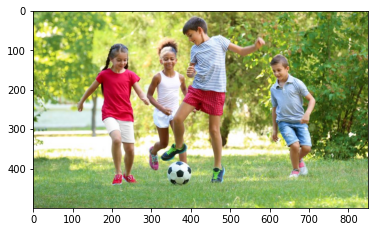

ResNet No Glove (Greedy): a group of children children children children cream cream cream cream cream
ResNet No Glove (K= 7)  : a group of children children children children cream cream cream cream cream
ResNet 50d (Greedy): a group of men in camouflage pants and <UNK> are standing in a line of a busy
ResNet 50d (K= 7)  : a group of men in matching outfits are standing in front of a mountain range
ResNet 300d (Greedy): a group of people are standing in front of a carnival
ResNet 300d (K= 7)  : a group of greyhound dogs racing around a track
Xception No Glove (Greedy): a boys in soccer soccer soccer soccer soccer soccer soccer soccer
Xception No Glove (K= 7)  : a boys in soccer soccer soccer soccer soccer soccer soccer soccer
Xception 50d (Greedy): a group of children are playing soccer in a park
Xception 50d (K= 7)  : a group of children are playing with a soccer ball
Xception 300d (Greedy): a little boy in a blue shirt chasing a soccer ball
Xception 300d (K= 7)  : children playing s

In [ ]:
x=plt.imread(img)
plt.imshow(x)
plt.show()

print("ResNet No Glove (Greedy):",generate_desc(model_2, feature_Res))
print("ResNet No Glove (K= 7)  :",beam_search_pred(model_2, feature_Res, wordtoix, K_beams = 7))
print("ResNet 50d (Greedy):",generate_desc(model_1, feature_Res))
print("ResNet 50d (K= 7)  :",beam_search_pred(model_1, feature_Res, wordtoix, K_beams = 7))
print("ResNet 300d (Greedy):",generate_desc(model, feature_Res))
print("ResNet 300d (K= 7)  :",beam_search_pred(model, feature_Res, wordtoix, K_beams = 7))
print("Xception No Glove (Greedy):",generate_desc(model_6, feature_X))
print("Xception No Glove (K= 7)  :",beam_search_pred(model_6, feature_X, wordtoix, K_beams = 7))
print("Xception 50d (Greedy):",generate_desc(model_4, feature_X))
print("Xception 50d (K= 7)  :",beam_search_pred(model_4, feature_X, wordtoix, K_beams = 7))
print("Xception 300d (Greedy):",generate_desc(model_5, feature_X))
print("Xception 300d (K= 7)  :",beam_search_pred(model_5, feature_X, wordtoix, K_beams = 7))